In [ ]:
#Import modules 
import torch.nn as nn
import torch
import numpy as np
from torch import exp, where, erf, tensor, sin, cos, log 
from torch import pow as POW
from numpy import pi
import matplotlib.pyplot as plt

In [ ]:
#https://arxiv.org/abs/2112.11687
#custom grad activation function helper for squareplus
class squarePlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):

        val = POW(data, 2) + 1
        
        #Save parameteres for backward function 
        ctx.save_for_backward(data, val)

        return 0.5*(POW(val, 0.5) + data) 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):

        #call parameters from forward function 
        (data, val) = ctx.saved_tensors

        grad = 0.5*(1 + data*POW(val, -0.5))
        
        return grad*grad_output

#Custom wrapper to make previous class a function 
class squarePlus(nn.Module):

    def __init__(self) -> None:
        super(squarePlus, self).__init__()
        self.fn =  squarePlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [ ]:
#https://arxiv.org/abs/2306.01822
#custom grad activation function helper for erf plus
class erfRelu_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        #Save parameteres for backward function 
        ctx.save_for_backward(data)

        return where(data < 0, np.sqrt(pi)/2*erf(data), data) #+ np.sqrt(pi)/2
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        #call parameters from forward function 
        (data, ) = ctx.saved_tensors

        grad = where(data < 0, exp(-POW(data, 2)), 1)
        
        return grad*grad_output

#Custom wrapper to make previous class a function 
class erfRelu(nn.Module):

    def __init__(self) -> None:
        super(erfRelu, self).__init__()
        self.fn = erfRelu_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [ ]:
#Our custom grad activation function helper for erf plus
class erfPlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        a = 1
        
        grad = where(data < 0, -erf(a*POW(data, -1)), 1)
        
        #Save parameteres for backward function 
        ctx.save_for_backward(data, grad)

        return data*grad
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        a = 1

        #call parameters from forward function 
        (data, grad) = ctx.saved_tensors

        val = a*POW(data, -1)

        grad = grad + where(data < 0, 2/np.sqrt(np.pi)*val*exp(-POW(val, 2)), 0)
        
        return grad*grad_output

#Custom wrapper to make previous class a function 
class erfPlus(nn.Module):

    def __init__(self) -> None:
        super(erfPlus, self).__init__()
        self.fn = erfPlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [ ]:

#custom grad activation function helper for degrreeeplus (A smooth two step activation function)
class degreePlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):

        a = 2*4

        val = POW(data, a) + 1
        
        #Save parameteres for backward function 
        ctx.save_for_backward(data, val)

        return 0.5*(POW(val, 1/a) + data) 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):

        a = 2*4 

        #call parameters from forward function 
        (data, val) = ctx.saved_tensors

        grad = 0.5*(1 + data**(a-1)*POW(val, 1/a-1))
        
        return grad*grad_output

#Custom wrapper to make previous class a function 
class degreePlus(nn.Module):

    def __init__(self) -> None:
        super(degreePlus, self).__init__()
        self.fn =  degreePlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [11]:
c = 1

In [ ]:
#Check that the gradients for each implemented activation function is correct 
if c == 1: 

    actFuncs = [erfPlus(), erfRelu(), squarePlus(), degreePlus()] 
    #Test function and to see if backward works 
    torch.manual_seed(2)
    
    data = torch.randn(50, dtype=torch.float64, requires_grad=True) 
            
    for actFunc in actFuncs:

        try: 
            torch.autograd.gradcheck(actFunc, data, eps=1e-8, atol=1e-7) 
            print(f'Gradient function {str(actFunc)} is correct')
        except: 
            print(f'Gradient function {str(actFunc)} is NOT correct')

Gradient function erfPlus() is correct
Gradient function erfRelu() is correct
Gradient function squarePlus() is correct
Gradient function degreePlus() is correct


In [13]:
#torch.autograd.gradcheck(testing_actFunc, data, eps=1e-8, atol=1e-7)

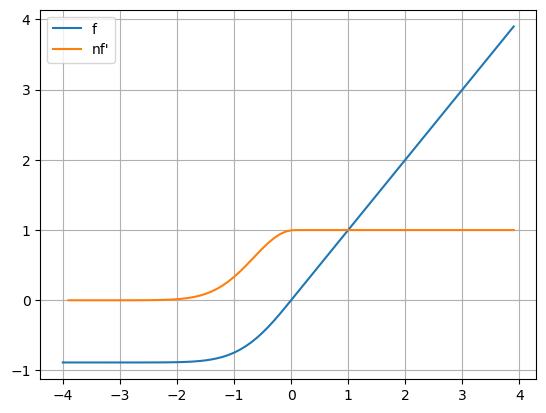

In [14]:
#Test if the function plots correct graph 
if c == 1: 
    dt = 0.1
    testing_actFunc = erfRelu()
    datax = torch.arange(-4, 4, dt, dtype=torch.float64, requires_grad=True) 
    
    datay = testing_actFunc.forward(datax)

    datad = (datay[1:]-datay[:-1])/dt
    
    plt.plot(datax.detach().numpy(), datay.detach().numpy(), label="f")
    plt.plot(datax[1:].detach().numpy(), datad.detach().numpy(), label="nf'")
    plt.grid()
    plt.legend()
    plt.show()